# Détection et sélection de points d'intêret

In [1]:
import numpy
import numpy.linalg
import scipy.io
import scipy.signal
import matplotlib.pyplot
import pathlib
import PIL.Image

## Lecture des images

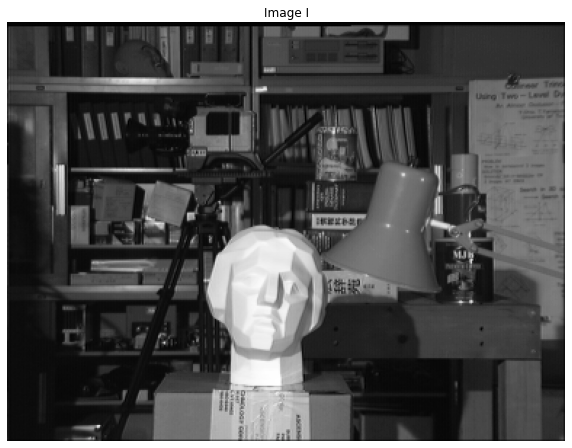

In [2]:
# Open image and convert to grayscale
path: pathlib.Path = pathlib.Path('./images/tsukuba/scene1.row3.col1.ppm')
img = numpy.array(PIL.Image.open(str(path)).convert('L'))

figure = matplotlib.pyplot.figure(figsize=(10, 10))

matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Image I')
_ = matplotlib.pyplot.imshow(img, cmap='gray')


## Calcul du gradient

### Sobel kernel

In [3]:
# Sobel for gradient x axe
hx = numpy.array(
    [
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]
)

# Sobel for gradient y axe
hy = hx.T

### Calcul du gradient par convolution 2D

$\begin{equation}
\nabla f = \begin{bmatrix}
    \frac{df}{dx} \\
    \frac{df}{dy}
\end{bmatrix}
\end{equation}$

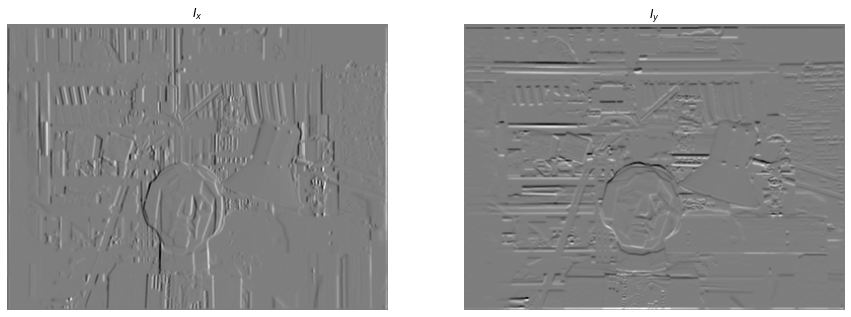

In [4]:
# Compute gradient

img_x = scipy.signal.convolve2d(img, hx)
img_y = scipy.signal.convolve2d(img, hy)

figure = matplotlib.pyplot.figure(figsize=(15, 15))

matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{x}$')
_ = matplotlib.pyplot.imshow(img_x, cmap='gray')

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{y}$')
_ = matplotlib.pyplot.imshow(img_y, cmap='gray')

### Calcul de la Hessienne par convolution 2D

$\begin{equation}
Hess_f = \begin{bmatrix}
    \frac{df}{dxdx} & \frac{df}{dxdy} \\
    \frac{df}{dydx} & \frac{df}{dydy}
\end{bmatrix}
\end{equation}$

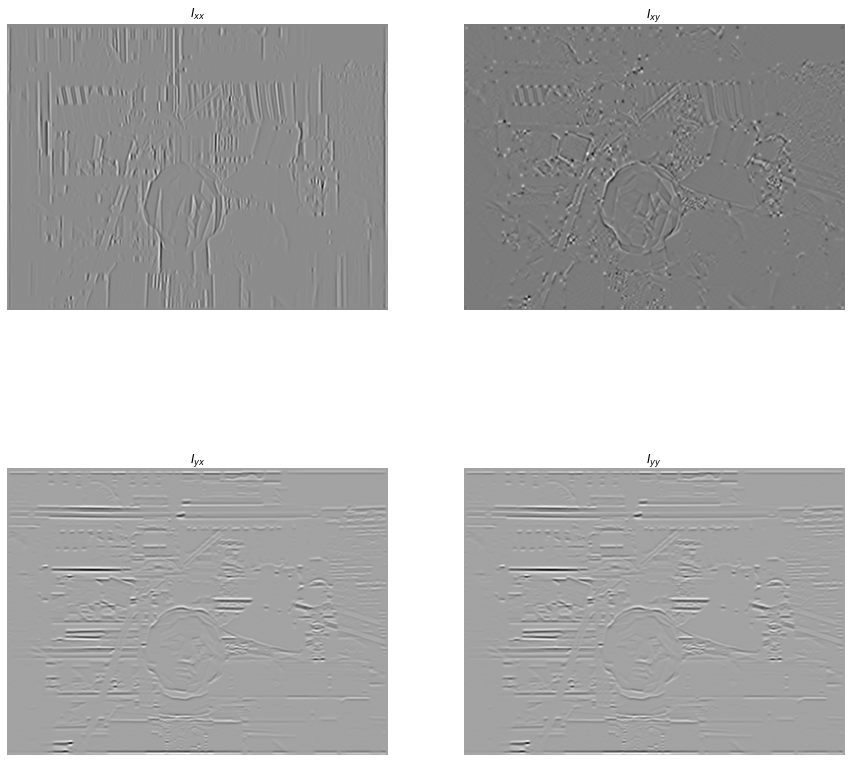

In [5]:
# Compute hessian

img_xx = scipy.signal.convolve2d(img_x, hx)
img_xy = scipy.signal.convolve2d(img_x, hy)
img_yx = scipy.signal.convolve2d(img_y, hy)
img_yy = scipy.signal.convolve2d(img_y, hy)

figure = matplotlib.pyplot.figure(figsize=(15, 15))

matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{xx}$')
_ = matplotlib.pyplot.imshow(img_xx, cmap='gray')


matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{xy}$')
_ = matplotlib.pyplot.imshow(img_xy, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{yx}$')
_ = matplotlib.pyplot.imshow(img_yx, cmap='gray')


matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{yy}$')
_ = matplotlib.pyplot.imshow(img_yy, cmap='gray')

## Calcul des reponses

### Detecteur de Moravec

In [6]:
def moravec_detector(img: numpy.ndarray, i: int, j: int, size_search: int) -> float:

    N, M = img.shape
    limit = size_search // 2

    if size_search%2 != 1:
        raise AssertionError('search_size must be odd')
        
    if (i-limit < 0) or (N-1-limit < i+1) or (j-limit < 0) or (M-1-limit < j+1):
        raise AssertionError('Bord condition : (i, j) = ({}, {})'.format(i, j))

    def SSD(i, j, u, v):
        return numpy.sum((img[i-limit:i+limit+1, j-limit:j+limit+1] - img[u-limit:u+limit+1, v-limit:v+limit+1])**2)
    
    ssds: list = []

    for k in range(-limit, limit+1):
        for l in range(-limit, limit+1):
            # Problème de condition de bord
            if (k != 0) and (l != 0):
                ssds.append(SSD(i, j, i+k, j+l))
            

    return numpy.min(numpy.array(ssds))



In [7]:
# Compute response

def response_moravec(img: numpy.ndarray, size_search: int) -> numpy.ndarray:
    
    if size_search%2 != 1:
        raise AssertionError('search_size must be odd')

    # limit = size_search // 2

    N, M = img.shape
    response = numpy.zeros(img.shape)

    for i in range(size_search, N-size_search):
        for j in range(size_search, M-size_search):
            response[i, j] = moravec_detector(img, i, j, size_search)


    return response

In [8]:
def remove_non_maxima(response: numpy.ndarray, size_search: int) -> numpy.ndarray:
    
    limit = size_search // 2
    response_p = response.copy()
    N, M = response_p.shape

    for i in range(limit, N-limit):
        for j in range(limit, M-limit):
            if response_p[i, j] != numpy.max(response_p[i-limit:i+limit+1, j-limit:j+limit+1]):
                response_p[i, j] = 0

    return response_p

In [9]:
# def select_best(response: numpy.ndarray, k: int) -> tuple[numpy.ndarray, numpy.ndarray]:
#     pass

def select_with_threshold(response: numpy.ndarray, threshold: int) -> tuple[numpy.ndarray, numpy.ndarray]:
    return numpy.where(response > threshold)

In [10]:
size_search: int = 3
R = response_moravec(img, size_search)
Rp = remove_non_maxima(R, size_search)

In [11]:
x, y = select_with_threshold(Rp, threshold=1_100)

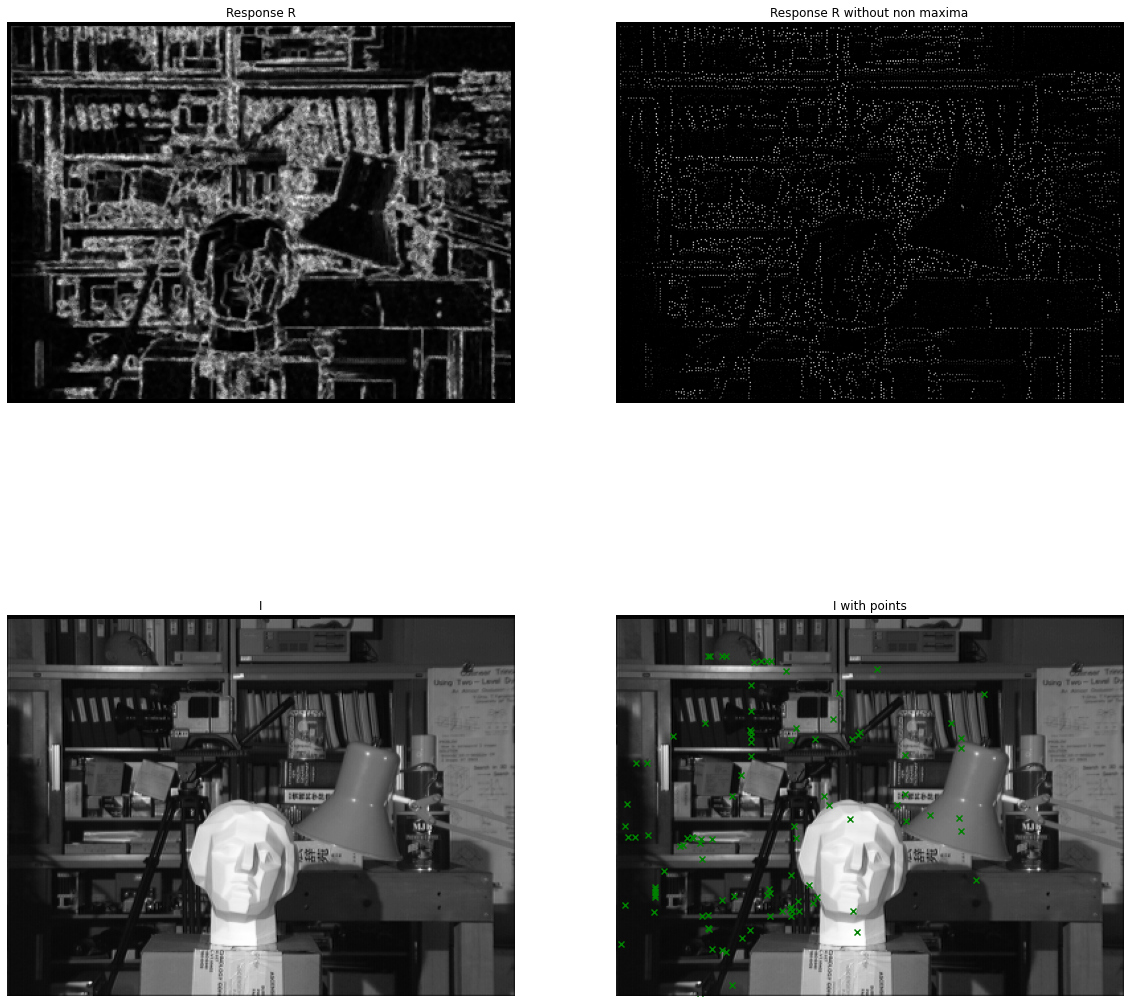

In [12]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))

matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Response R')
# R[5 < R] = 0
_ = matplotlib.pyplot.imshow(R, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Response R without non maxima')
# R[5 < R] = 0
_ = matplotlib.pyplot.imshow(Rp, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('I')
_ = matplotlib.pyplot.imshow(img, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('I with points')
matplotlib.pyplot.scatter(x, y, marker='x', color="green")
_ = matplotlib.pyplot.imshow(img, cmap='gray')

### Detecteur de Kitchen-Rosenfeld

In [13]:
def kitchen_rosenfeld_detector(
    img_x: numpy.ndarray, 
    img_y: numpy.ndarray, 
    img_xx: numpy.ndarray, 
    img_xy: numpy.ndarray, 
    img_yx: numpy.ndarray, 
    img_yy: numpy.ndarray
) -> numpy.ndarray:

    img_x2 = img_x**2
    img_y2 = img_y**2

    # Voir si il n'y a pas de pb avec une divison par zero
    return (img_xx*img_y2 + img_yy*img_x2 - img_xy**img_x*img_y - img_yx*img_x*img_y) / (img_x2 + img_y2)
    # return (img_xx*img_y2 + img_yy*img_x2 - 2*img_xy*img_x*img_y) / (img_x2 + img_y2)


### Detecteur de Beaudet

In [14]:
def beaudet_detector(
    img_xx: numpy.ndarray, 
    img_xy: numpy.ndarray, 
    img_yx: numpy.ndarray, 
    img_yy: numpy.ndarray
) -> numpy.ndarray:
    return numpy.abs(img_xx*img_yy-img_xy*img_yx)

### Detecteur de Harris

In [15]:
def harris_detector():
    pass

### Detecteur de Harris multi-échelle

In [16]:
def harris_multi_scaling_detector():
    pass

### Detecteur de Harris-Laplace

In [17]:
def harris_laplace_detector():
    pass

### Detecteur de SIFT

In [18]:
def sift_detector():
    pass